In [51]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from ta.volatility import AverageTrueRange
from ta.momentum import RSIIndicator
import yfinance as yf

from lstm_functions import *
from lost_functions import *

# Reading and storing the Data

In [52]:
raw_data = {}
stock_list = ["XOM", "SHW", "UPS", "DUK", "UNH", "JPM", "AMZN", "AAPL", "MSFT", "AMT"]
start_date = '2000-01-01'
end_date = '2021-12-31'

# Initialize an empty DataFrame to store the data
all_data = pd.DataFrame()

# Loop through each stock symbol
for symbol in stock_list:
    # Download historical data from Yahoo Finance
    data = yf.download(symbol, start=start_date, end=end_date)
    
    # Calculate ATR (Average True Range)
    data['ATR'] = AverageTrueRange(high=data['High'], low=data['Low'], close=data['Close'], window=14).average_true_range()
    
    # Calculate RSI (Relative Strength Index)
    data['RSI'] = RSIIndicator(close=data['Close'], window=14).rsi()
    
    # Select the features you're interested in
    features = data[['ATR', 'RSI', 'Volume', 'Adj Close']]
    features['Adj Close'] = features['Adj Close'].shift(1)
    
    # Drop rows with NaN values (if any)
    features = features.dropna()
    
    raw_data[symbol] = features

raw_data

[*********************100%%**********************]  1 of 1 completed


/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_41807/2824289101.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Adj Close'] = features['Adj Close'].shift(1)


[*********************100%%**********************]  1 of 1 completed


/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_41807/2824289101.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Adj Close'] = features['Adj Close'].shift(1)


[*********************100%%**********************]  1 of 1 completed


/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_41807/2824289101.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Adj Close'] = features['Adj Close'].shift(1)


[*********************100%%**********************]  1 of 1 completed


/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_41807/2824289101.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Adj Close'] = features['Adj Close'].shift(1)


[*********************100%%**********************]  1 of 1 completed


/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_41807/2824289101.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Adj Close'] = features['Adj Close'].shift(1)


[*********************100%%**********************]  1 of 1 completed


/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_41807/2824289101.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Adj Close'] = features['Adj Close'].shift(1)


[*********************100%%**********************]  1 of 1 completed


/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_41807/2824289101.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Adj Close'] = features['Adj Close'].shift(1)


[*********************100%%**********************]  1 of 1 completed


/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_41807/2824289101.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Adj Close'] = features['Adj Close'].shift(1)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_41807/2824289101.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Adj Close'] = features['Adj Close'].shift(1)
/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_41807/2824289101.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Adj Close'] = features['Adj Close'].shift(1)


{'XOM':                  ATR        RSI    Volume  Adj Close
 Date                                                
 2000-01-21  1.339286  63.336192  14343600  19.949492
 2000-01-24  1.361926  59.595089  12459400  20.262365
 2000-01-25  1.347235  58.662199  11921600  20.083580
 2000-01-26  1.317968  55.838243   9298000  20.038889
 2000-01-27  1.357756  45.381810  10548400  19.904802
 ...              ...        ...       ...        ...
 2021-12-23  1.515455  46.865506  13543300  57.244816
 2021-12-27  1.516494  51.427811  12593700  57.272972
 2021-12-28  1.473173  50.357357  12781000  58.089546
 2021-12-29  1.422947  47.483547  12733600  57.901833
 2021-12-30  1.380593  45.614607  11940300  57.394993
 
 [5522 rows x 4 columns],
 'SHW':                  ATR        RSI   Volume   Adj Close
 Date                                                
 2000-01-21  0.242559  21.491617  3363900    4.047309
 2000-01-24  0.240859  23.416933  1954800    4.104715
 2000-01-25  0.243000  25.387373  250500

generating weights for y_true

In [53]:
### question: not possible to normalise to (-1, 1) and sum to 0, need solve optimisation problem?

price_data = pd.concat([raw_data[i]['Adj Close'] for i in stock_list], axis=1)
price_data.columns = stock_list

## get the % returns
returns_data = price_data.pct_change().iloc[1:, :] 

## normalize weights to (0, 1)
sc = MinMaxScaler(feature_range = (0, 1))
weights_data = pd.DataFrame(sc.fit_transform(returns_data.T).T)

## Sum weights to 1
weights_data['total'] = weights_data.sum(axis=1)
for col in weights_data.columns:
    weights_data[col] = weights_data[col]/weights_data['total']
weights_data = weights_data.drop(columns=['total'])
weights_array = weights_data.values

weights_data.head()

,0,1,2,3,4,5,6,7,8,9
0,0.157203,0.153188,0.052044,0.148190,0.000000,0.074544,0.004088,0.063613,0.058383,0.288747
1,0.088739,0.112621,0.069814,0.131573,0.000000,0.107504,0.357654,0.017685,0.059134,0.055276
2,0.062833,0.088199,0.064305,0.058169,0.072719,0.171614,0.017286,0.323595,0.141280,0.000000
3,0.112131,0.104853,0.102959,0.133765,0.120780,0.225027,0.000000,0.089304,0.059877,0.051305
4,0.013851,0.123907,0.103011,0.132237,0.055688,0.188433,0.200648,0.097944,0.084280,0.000000


data preprocessing

In [54]:
## compress into 3x6 features

data = pd.concat([raw_data[i] for i in stock_list], axis=1)[1:]
data.head()

,ATR,RSI,Volume,Adj Close,ATR,RSI,Volume,Adj Close,ATR,RSI,...,Volume,Adj Close,ATR,RSI,Volume,Adj Close,ATR,RSI,Volume,Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-24,1.361926,59.595089,12459400,20.262365,0.240859,23.416933,1954800,4.104715,1.984694,43.142939,...,440876800,0.843587,2.791932,30.172140,63597600,32.225903,1.987564,83.232596,2161100,34.011345
2000-01-25,1.347235,58.662199,11921600,20.083580,0.243000,25.387373,2505000,4.119068,1.976859,42.597298,...,497145600,0.805220,2.746527,34.237594,59823200,31.449362,1.988452,78.421600,788000,33.124081
2000-01-26,1.317968,55.838243,9298000,20.038889,0.240524,23.438959,1578000,4.133420,1.933869,39.379191,...,367158400,0.850691,2.706596,30.087367,49365000,31.934700,2.042848,68.702106,578600,32.581886
2000-01-27,1.357756,45.381810,10548400,19.904802,0.235248,27.437246,1505100,4.090365,1.893950,39.379191,...,340144000,0.835060,2.653893,29.389798,63654800,30.866983,2.062109,61.480813,975700,31.349581
2000-01-28,1.336666,38.740933,10361000,19.308849,0.230349,22.398455,1428300,4.119068,1.892596,38.535109,...,423348800,0.833640,2.571472,28.814246,58225400,30.672834,2.066601,58.759806,601300,30.265162


In [55]:
train_size = int(len(data) * 0.8)
sc = MinMaxScaler(feature_range = (0, 1))

weights_array_train = weights_array[:train_size]
weights_array_test = weights_array[train_size:]


train_data = data.iloc[:train_size]
train_array = train_data.values
train_scaled = sc.fit_transform(train_array)
test_data = data.iloc[train_size:]
test_array = test_data.values
test_scaled = sc.fit_transform(test_array)

train, test = np.array(train_scaled), np.array(test_scaled)
print(train.shape)
print(test.shape)

## table containing prices of test set (for portfolio evaluation)
test_prices = price_data[train_size:].copy(deep=True)
test_prices = test_prices[31:]  ## batch_size=30 and first value of y is 0 due to pct_change diff
print(test_prices)

(4416, 40)
(1105, 40)
                  XOM         SHW         UPS        DUK         UNH  \
Date                                                                   
2017-09-25  59.414742  110.483742   97.512527  65.613930  176.754364   
2017-09-26  60.202805  111.191315   97.968300  66.307068  175.582291   
2017-09-27  60.135868  111.235542   98.548401  66.057854  176.452179   
2017-09-28  60.537338  110.509018   98.299805  65.372513  178.091278   
2017-09-29  61.102360  112.783379   99.120209  65.621719  179.565536   
...               ...         ...         ...        ...         ...   
2021-12-23  57.244816  332.973083  196.318771  96.181526  482.285309   
2021-12-27  57.272972  332.638794  199.850708  96.004379  483.505341   
2021-12-28  58.089546  339.687164  202.600906  96.302742  487.526581   
2021-12-29  57.901833  342.488861  202.195908  97.496140  490.884125   
2021-12-30  57.394993  345.398651  202.120575  97.673286  493.460846   

                   JPM        AMZN       

data structure creation

In [73]:
batch_size = 30

x_train, y_train = [], []
x_test, y_test = [], []

for i in range(batch_size, train.shape[0]):
    x_train.append(train[i-batch_size: i, :])
    y_train.append(weights_array_train[i, :])

for i in range(batch_size, test.shape[0]):
    x_test.append(test[i-batch_size: i, :])
    y_test.append(weights_array_test[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)
print(y_test[0])

[0.17655044 0.17734408 0.22248546 0.01376248 0.00667496 0.14005626
 0.02533168 0.02710601 0.21068862 0.        ]


model initiation

In [57]:
num_units = [50, 40, 40, 40]

model = Sequential()

## can comment out FC layers too, but change first LSTM 2nd input to x_train.shape[2]
model.add(Dense(units=num_units[0], activation='swish', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(units=num_units[1], activation='swish'))
model.add(Dense(units=num_units[2], activation='swish'))
model.add(Dense(units=num_units[3], activation='swish'))

model.add(LSTM(units=30, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], num_units[3])))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=30, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=30, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=30, activation='relu', return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))

model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 30, 50)            2050      
                                                                 
 dense_39 (Dense)            (None, 30, 40)            2040      
                                                                 
 dense_40 (Dense)            (None, 30, 40)            1640      
                                                                 
 dense_41 (Dense)            (None, 30, 40)            1640      
                                                                 
 lstm_26 (LSTM)              (None, 30, 30)            8520      
                                                                 
 dropout_26 (Dropout)        (None, 30, 30)            0         
                                                                 
 lstm_27 (LSTM)              (None, 30, 30)           

In [58]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x=x_train, y=y_train, batch_size=64, epochs=10)

Epoch 1/10
69/69 [==============================] - 4s 25ms/step - loss: 0.0579
Epoch 2/10
69/69 [==============================] - 2s 28ms/step - loss: 0.0082
Epoch 3/10
69/69 [==============================] - 2s 30ms/step - loss: 0.0072
Epoch 4/10
69/69 [==============================] - 2s 30ms/step - loss: 0.0067
Epoch 5/10
69/69 [==============================] - 2s 30ms/step - loss: 0.0064
Epoch 6/10
69/69 [==============================] - 2s 30ms/step - loss: 0.0063
Epoch 7/10
69/69 [==============================] - 2s 30ms/step - loss: 0.0060
Epoch 8/10
69/69 [==============================] - 2s 30ms/step - loss: 0.0059
Epoch 9/10
69/69 [==============================] - 2s 30ms/step - loss: 0.0058
Epoch 10/10
69/69 [==============================] - 2s 30ms/step - loss: 0.0058


In [59]:
# from keras.optimizers import Adam

# # Tuning parameters 
# param_space = {
#     'units_lstm': [20, 30, 40, 50],
#     'units_fc1': [10, 20, 30, 40],
#     'units_fc2': [10, 20, 30, 40],
#     'units_fc3': [10, 20, 30, 40],
#     'epochs': [10, 20, 30],
#     'batch_size': [32, 64, 128],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'dropout_rate': [0.1, 0.2, 0.3],
#     'loss': ['mean_squared_error', 'mean_absolute_error'],
#     'layers': [1, 2, 3]
# }

# num_configs = 30
# best_loss = float('inf')
# best_hyperparameters = {}

# for _ in range(num_configs):
#     hyperparameters = {param: random.choice(values) for param, values in param_space.items()}

#     model = Sequential()
#     model.add(Dense(units=hyperparameters['units_lstm'], activation='swish'))
#     # Adding Dense layers
#     for i in range(hyperparameters['layers']):
#         units = hyperparameters[f'units_fc{i+1}']
#         model.add(Dense(units=units, activation='swish'))
    
#     # Adding LSTM layers
#     for i in range(hyperparameters['layers']):
#         units = hyperparameters['units_lstm']
#         model.add(LSTM(units=units, activation='relu', return_sequences=True if i < 2 else False))
#         model.add(Dropout(rate=hyperparameters['dropout_rate']))

#     # Adding output Dense layer
#     model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

#     model.compile(optimizer=Adam(learning_rate=hyperparameters['learning_rate']), loss='mean_squared_error')

#     # Train the model
#     history = model.fit(x=x_train, y=y_train, batch_size=hyperparameters['batch_size'],
#                         epochs=hyperparameters['epochs'], verbose=0)

#     val_loss = model.evaluate(x_test, y_test, verbose=0)

#     if val_loss < best_loss:
#         best_loss = val_loss
#         best_hyperparameters = hyperparameters

# # Print the best hyperparameters
# print("Best Hyperparameters:")
# print(best_hyperparameters)

# # Train the final model with the best hyperparameters
# final_model = Sequential()

# # Adding Dense layers
# model.add(Dense(units=hyperparameters['units_lstm'], activation='swish'))
# for i in range(best_hyperparameters['layers']):
#     units = best_hyperparameters[f'units_fc{i+1}']
#     final_model.add(Dense(units=units, activation='swish'))

# # Adding LSTM layers
# for i in range(best_hyperparameters['layers']):
#     units = best_hyperparameters['units_lstm']
#     final_model.add(LSTM(units=units, activation='relu', return_sequences=True if i < 2 else False))
#     final_model.add(Dropout(rate=best_hyperparameters['dropout_rate']))

# final_model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

# final_model.compile(optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']), loss=best_hyperparameters['loss'])
# final_model.fit(x=x_train, y=y_train, batch_size=best_hyperparameters['batch_size'], epochs=best_hyperparameters['epochs'])

![Alt text](image-2.png)

model prediction

In [60]:
y_pred = model.predict(x_test)
# y_pred_test = final_model.predict(x_test)

34/34 [==============================] - 0s 5ms/step


In [61]:
# print(y_pred.shape)
# print(y_pred_test.shape)
print(y_test.shape)

(1075, 10)


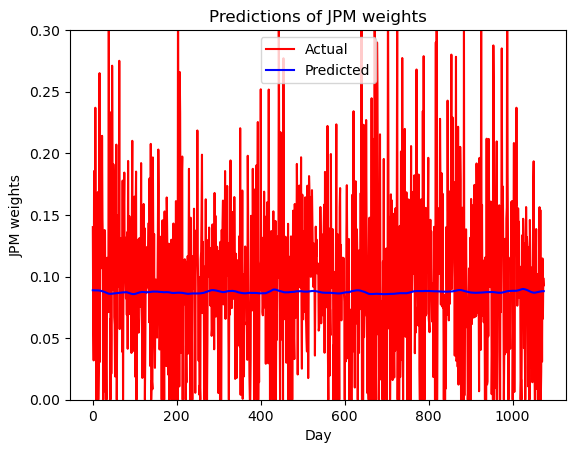

In [62]:
stock = 'JPM'             # XOM, SHW, UPS, DUK, UNH, JPM, AMZN, AAPL, MSFT, AMT
col = stock_list.index(stock)

plt.plot(y_test[:, col], color='red', label='Actual')
plt.plot(y_pred[:, col], color='blue', label='Predicted')
plt.title(f'Predictions of {stock} weights')
plt.xlabel('Day')
plt.ylabel(f'{stock} weights')
plt.ylim([0, 0.3])
plt.legend()
plt.show()

In [63]:
print(f'y_pred: {y_pred[0]}')
print(f'y_test: {y_test[0]}')

y_pred: [0.08316803 0.08457733 0.08684618 0.08578522 0.09275668 0.08887848
 0.09568566 0.09866729 0.086188   0.09225123]
y_test: [0.17655044 0.17734408 0.22248546 0.01376248 0.00667496 0.14005626
 0.02533168 0.02710601 0.21068862 0.        ]


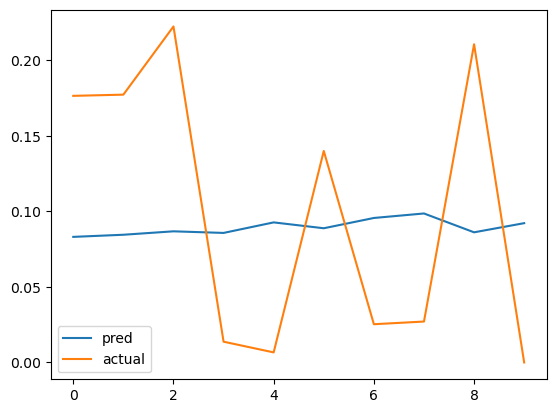

In [64]:
plt.plot(y_pred[0], label='pred')
plt.plot(y_test[0], label='actual')
plt.legend()
plt.show()

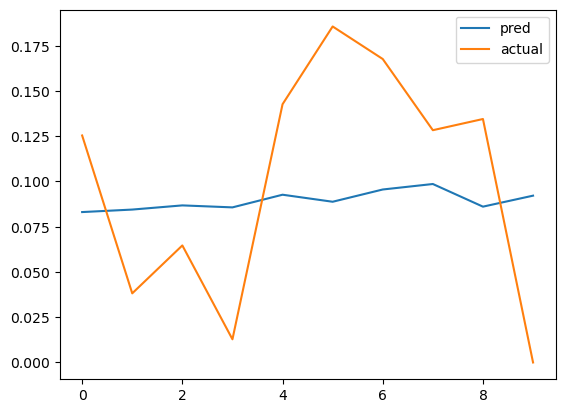

In [65]:
plt.plot(y_pred[3], label='pred')
plt.plot(y_test[3], label='actual')
plt.legend()
plt.show()

generate table of stock weights

In [66]:
weights_pred = pd.DataFrame(y_pred)
weights_pred.columns = stock_list
weights_pred.index = test_prices.index.copy()
weights_pred.head()

# weights_pred_test = pd.DataFrame(y_pred_test)
# weights_pred_test.columns = stock_list
# weights_pred_test.index = test_prices.index.copy()

,XOM,SHW,UPS,DUK,UNH,JPM,AMZN,AAPL,MSFT,AMT
Date,,,,,,,,,,
2017-09-25,0.083168,0.084577,0.086846,0.085785,0.092757,0.088878,0.095686,0.098667,0.086188,0.092251
2017-09-26,0.083114,0.084508,0.086798,0.085718,0.092703,0.088822,0.095609,0.098617,0.086122,0.092188
2017-09-27,0.083107,0.084494,0.086792,0.085704,0.092693,0.088812,0.095589,0.098610,0.086108,0.092176
2017-09-28,0.083110,0.084490,0.086795,0.085699,0.092695,0.088810,0.095581,0.098614,0.086103,0.092176
2017-09-29,0.083123,0.084494,0.086806,0.085703,0.092707,0.088818,0.095583,0.098627,0.086107,0.092186


portfolio evaluation

Index(['XOM', 'SHW', 'UPS', 'DUK', 'UNH', 'JPM', 'AMZN', 'AAPL', 'MSFT',
       'AMT'],
      dtype='object')
Annualized Return: 23.81%
Annualized Volatility: 18.39%
Sharpe Ratio: 1.13
Maximum Drawdown: -27.43%


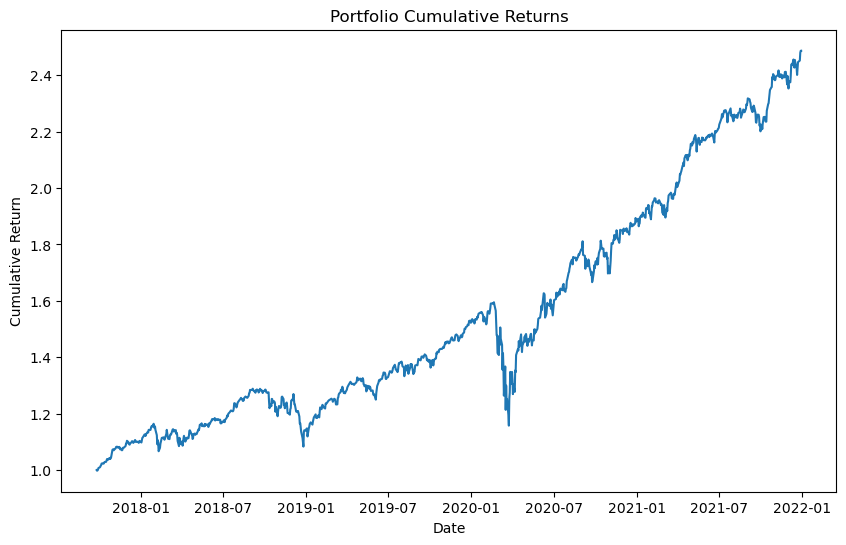

In [67]:
def backtest(test_df, weights):
    '''
    df of stocks with index being date, cols being stocks, each entry being the price 
    weights represent the normalized portfolio weights
    '''
    returns = test_df.pct_change().dropna()

    portfolio_returns = (returns * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    # print(cumulative_returns)
    annualized_return = (cumulative_returns[-1])**(252/len(cumulative_returns.index)) - 1  # Assuming 252 trading days
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)

    # Calculate Sharpe Ratio
    risk_free_rate = 0.03 # can change 
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Calculate Maximum Drawdown
    cumulative_returns_index = (1 + portfolio_returns).cumprod()
    cumulative_max = cumulative_returns_index.cummax()
    drawdown = (cumulative_returns_index - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")

    plt.figure(figsize=(10,6))
    plt.plot(cumulative_returns)
    plt.title('Portfolio Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.show()
print(test_prices.columns)
backtest(test_prices, weights_pred)
# backtest(test_prices, weights_pred_test)

In [68]:

def backtest_2(test_df, weights):
    '''
    df of stocks with index being date, cols being stocks, each entry being the price 
    weights represent the normalized portfolio weights, a matrix of dimension (n_days, n_stocks)
    '''
    returns = test_df.pct_change().dropna()
    # zeros_row = pd.DataFrame(np.zeros((1, 10)), columns=returns.columns)
    # returns = pd.concat([zeros_row, returns])

    portfolio_returns = (returns * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    print(cumulative_returns)
    annualized_return = (cumulative_returns[-1])**(252/len(cumulative_returns.index)) - 1  # Assuming 252 trading days
    annualized_volatility = np.std(portfolio_returns, axis=0) * np.sqrt(252)

    # Calculate Sharpe Ratio
    risk_free_rate = 0.03 # can change 
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Calculate Maximum Drawdown
    cumulative_returns_index = (1 + portfolio_returns).cumprod()
    cumulative_max = cumulative_returns_index.cummax()
    drawdown = (cumulative_returns_index - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")

    plt.figure(figsize=(10,6))
    plt.plot(cumulative_returns)
    plt.title('Portfolio Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.show()


                 UNH       SHW       AMT      AAPL      AMZN       UPS  \
Date                                                                     
2009-01-07  0.164404  0.067186  0.115071  0.107395  0.029342  0.138388   
2009-01-08  0.014733  0.194477  0.187308  0.012285  0.015706  0.176191   
2009-01-09  0.052349  0.084657  0.186306  0.170493  0.200987  0.004604   
2009-01-12  0.166001  0.155690  0.047071  0.117566  0.000719  0.121804   
2009-01-13  0.168519  0.067891  0.013539  0.134993  0.158203  0.000643   
...              ...       ...       ...       ...       ...       ...   
2019-12-24  0.104058  0.110231  0.158857  0.080100  0.119535  0.211043   
2019-12-26  0.045781  0.007739  0.158184  0.170718  0.187083  0.041504   
2019-12-27  0.170066  0.092102  0.011192  0.074444  0.060408  0.186011   
2019-12-30  0.014216  0.104222  0.137379  0.036052  0.178288  0.070137   
2019-12-31  0.168228  0.135069  0.063342  0.167674  0.135512  0.069365   

                 DUK       XOM       

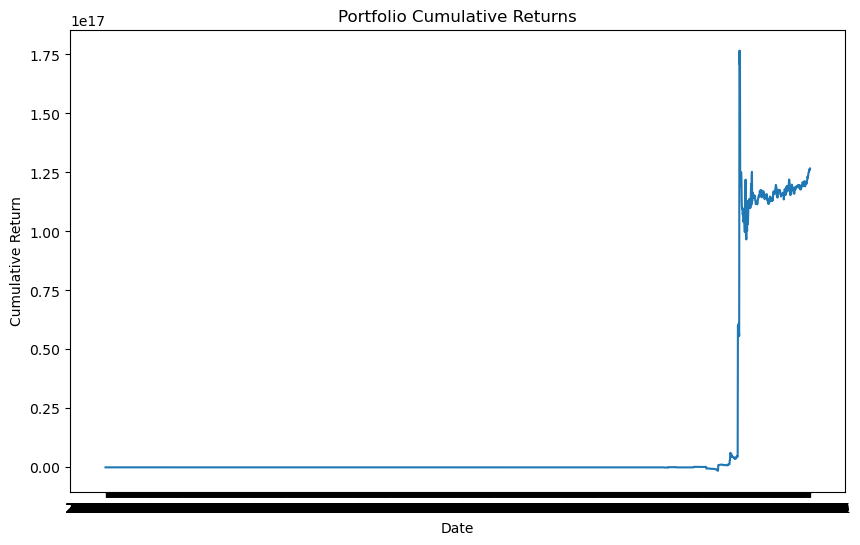

In [69]:
alvin_test = pd.read_csv('truth2.csv').set_index('Date')
weights = pd.read_csv('weights2.csv').set_index('Date')
data = np.random.rand(2765, 10)
# Normalize each column to sum to 1
normalized_data = data / data.sum(axis=1, keepdims=True)

# Create a DataFrame
random_weights = pd.DataFrame(normalized_data, index=alvin_test.index, columns=alvin_test.columns)
print(random_weights)
backtest_2(alvin_test, weights)

In [70]:
def custom_loss_1(y_true, y_pred):
    # y_true is the s&p500 returns
    # y_pred is the array of weights for each stock
    # we want to maximise y_pred - s&p500 returns (at least 20% higher)
    # aka minimise s&p500 returns - y_pred

    # <normalize>
    # predicted weights for day i * returns on day i = total returns
    # compare w s&p500 returns

    return y_true*1.2 - y_pred